In [1]:
from matplotlib import pyplot as plt
from jax import numpy as jnp
import jax
from exponential_families import *
from matplotlib import ticker
from tueplots import bundles
from tueplots.constants.color import rgb

plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({"figure.dpi": 200})

The [**Poisson distribution**](https://en.wikipedia.org/wiki/Poisson_distribution) is a discrete probability distribution over the number of events occuring in a fixed interval of time or space: 
$$ p(k; \lambda) = \frac{\lambda^k e^{-\lambda}}{k!}$$
It's evidently an exponential family:
$$ p(k;\lambda) = \frac{1}{k!} \exp\left( k\log\lambda -\lambda \right) = \frac{1}{k!} \exp\left( kw -e^w \right) $$

In [2]:
class Poisson(ExponentialFamily):
    """The Poisson distribution."""

    def __init__(self) -> None:
        """The Poisson has no fixed parameters."""
        super().__init__()

    def sufficient_statistics(self, k: ArrayLike | jnp.ndarray) -> jnp.ndarray:
        """The sufficient statistics are the identity function."""
        return jnp.asarray(k)

    def log_base_measure(self, k: ArrayLike | jnp.ndarray) -> jnp.ndarray:
        """h(k) = 1/k!, thus log h(k) = -log(k!)"""
        k = jnp.asarray(k)
        return -jax.scipy.special.gammaln(k[..., 0] + 1)

    def log_partition(self, lambdas: ArrayLike | jnp.ndarray) -> jnp.ndarray:
        """log Z(lambda) = lambda"""
        lambdas = jnp.asarray(lambdas)
        return lambdas[..., 0]

    def parameters_to_natural_parameters(
        self, lambdas: ArrayLike | jnp.ndarray
    ) -> jnp.ndarray:
        """eta = log(lambda)."""
        lambdas = jnp.asarray(lambdas)
        return jnp.log(lambdas)

    # let's skip this at first glance:
    def conjugate_log_partition(
        self, alpha: ArrayLike | jnp.ndarray, nu: ArrayLike | jnp.ndarray
    ) -> jnp.ndarray:
        """log Z(alpha, nu) = Gamma(alpha+1) / nu^{alpha+1}"""
        return jax.scipy.special.gammaln(alpha + 1) - (alpha + 1) * jnp.log(nu)

Text(0.5, 1.0, 'likelihood of $\\lambda$')

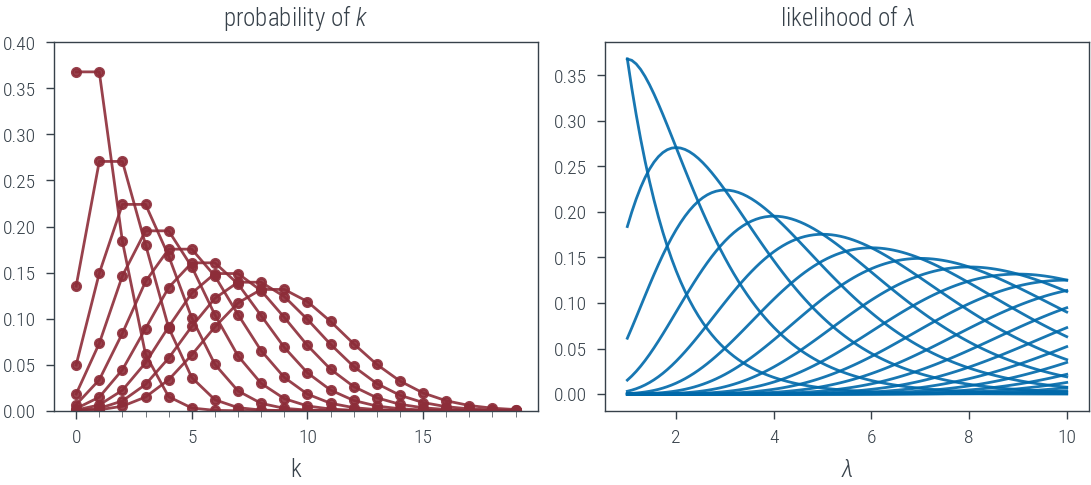

In [3]:
likelihood = Poisson()

lambdas = jnp.arange(1, 10)
fig, axs = plt.subplots(1, 2)
ks = jnp.arange(0, 20)
ax = axs[0]
for lam in lambdas:
    ax.plot(
        ks,
        jnp.exp(likelihood.logpdf(ks[..., None], [lam])),
        "o-",
        ms=3,
        color=rgb.tue_red,
        label="$p(k;\lambda)$",
        alpha=0.9,
    )
ax.set_xlabel("k")
ax.set_title("probability of $k$")
ax.set_ylim(0, 0.4)
# ax.plot(k, jnp.exp(k * jnp.log(lam) - lam - jax.scipy.special.gammaln(k + 1)), "o-", ms=3, color=rgb.tue_blue, label="$\exp(k \log \lambda - \lambda - \log k!)$", alpha=0.9)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

ax = axs[1]
lambdas = jnp.linspace(1, 10, 100)
ax.plot(
    lambdas,
    jnp.exp(likelihood.logpdf(ks[..., None], lambdas[..., None, None])),
    "-",
    ms=3,
    color=rgb.tue_blue,
    label="$p(k;\lambda)$",
    alpha=0.9,
)
ax.set_xlabel("$\lambda$")
ax.set_title("likelihood of $\lambda$")

The conjugate prior for
$$ p(k;\lambda) = \frac{1}{k!} \exp\left( k\log\lambda -\lambda \right) $$
has the sufficient statistics $\log\lambda, -\lambda$, and thus is of the form
$$ p(\lambda\mid \alpha,\nu) = \exp((\log\lambda)\alpha - \lambda \nu - \log F(\alpha,\nu))
= \frac{\lambda^\alpha e^{-\lambda\nu}}{F(\alpha,\nu)} $$
That's the [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution), and has the normalization constant
$$F(\alpha,\nu) = \frac{\Gamma(\alpha+1)}{\nu^{\alpha+1}} $$
Bayesian inference on Poisson distributed data thus "simply" becomes:

Text(0.5, 0, '$\\lambda$')

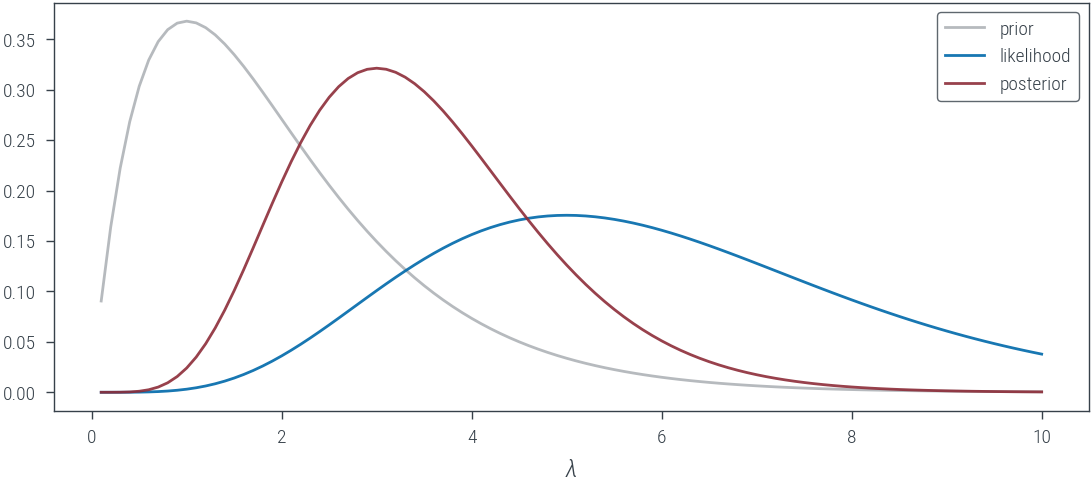

In [4]:
likelihood = Poisson()  # identify the model
prior = (
    likelihood.conjugate_prior()
)  # the model induces the conjugate prior (if we know its partition function)
prior_natural_parameters = [1, 1]  # just pick one particular prior
data = [5]  # let's say we've seen this many events in a certain time interval
posterior = prior  # conjugate inference! So easy!
# we just need to update the _parameters_. The likelihood tells us how to do that:
posterior_natural_parameters = likelihood.posterior_parameters(
    prior_natural_parameters, data
)


lambdas = jnp.linspace(0.1, 10, 100)
fig, ax = plt.subplots()
ax.plot(
    lambdas,
    jnp.exp(prior.logpdf(lambdas[..., None], prior_natural_parameters)),
    "-",
    color=rgb.tue_gray,
    label="prior",
    alpha=0.9,
)
ax.plot(
    lambdas,
    jnp.exp(likelihood.logpdf(data, lambdas[..., None])),
    "-",
    color=rgb.tue_blue,
    label="likelihood",
    alpha=0.9,
)
ax.plot(
    lambdas,
    jnp.exp(posterior.logpdf(lambdas[..., None], posterior_natural_parameters)),
    "-",
    color=rgb.tue_red,
    label="posterior",
    alpha=0.9,
)


ax.legend()
ax.set_xlabel("$\lambda$")

## The *Bagel* distribution
$$ \mathcal{H}(x;\theta) = \frac{\theta_1}{\pi} e^{2\theta_1\theta_2} e^{-\theta_1 ^2 x^2 - \theta_2 ^2 / x^2} $$

In [5]:
from jax import numpy as jnp
from numpy.typing import ArrayLike


class BagelDistribution(ExponentialFamily):
    def sufficient_statistics(self, x: ArrayLike | jnp.ndarray) -> jnp.ndarray:
        return -(jnp.asarray(x) ** jnp.asarray([2.0, -2.0]))

    def log_base_measure(self, x: ArrayLike | jnp.ndarray) -> jnp.ndarray:
        x = jnp.asarray(x)
        return jnp.zeros_like(x[..., 0])

    def parameters_to_natural_parameters(
        self, thetas: ArrayLike | jnp.ndarray
    ) -> jnp.ndarray:
        thetas = jnp.asarray(thetas)
        return thetas**2

    def log_partition(self, thetas: ArrayLike | jnp.ndarray) -> jnp.ndarray:
        thetas = jnp.abs(jnp.asarray(thetas))
        return (
            0.5 * jnp.log(jnp.pi) - jnp.log(thetas[..., 0]) - 2 * thetas.prod(axis=-1)
        )

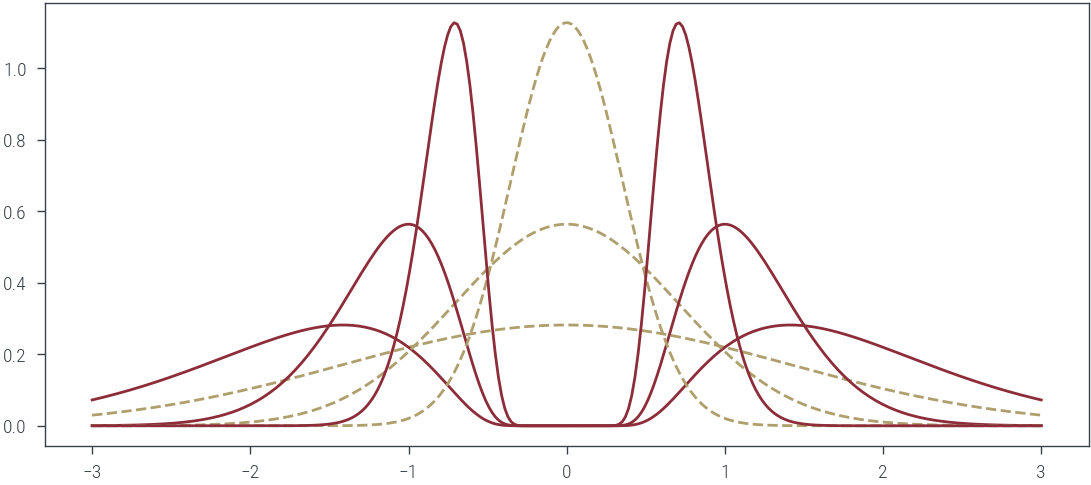

In [6]:
xp = np.linspace(-3, 3, 300)
fig, ax = plt.subplots()

bagel_likelihood = BagelDistribution()
for w0 in [0.5, 1.0, 2.0]:
    ax.plot(
        xp,
        jnp.exp(bagel_likelihood.logpdf(xp[..., None], [w0, 0.0])),
        "--",
        c=rgb.tue_gold,
    )
    ax.plot(
        xp, jnp.exp(bagel_likelihood.logpdf(xp[..., None], [w0, 1.0])), c=rgb.tue_red
    )

Text(0, 0.5, '$\\theta_2$')

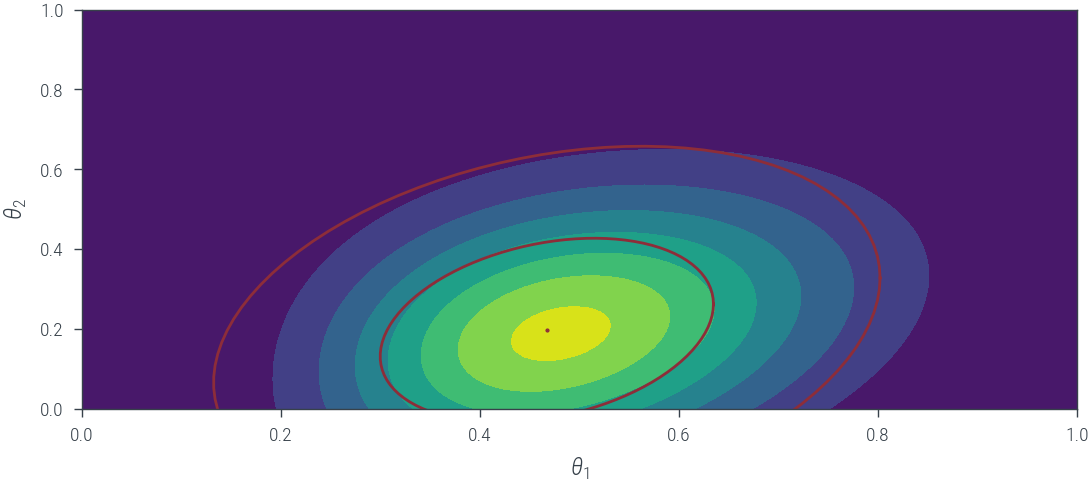

In [17]:
fig, ax = plt.subplots()
bagel_prior = bagel_likelihood.conjugate_prior()
alpha_1 = -0.5
alpha_2 = -0.5
nu = 0.0
prior_params = [alpha_1, alpha_2, nu]
thetas = np.stack(
    np.meshgrid(np.linspace(0, 1.0, 100), np.linspace(0, 1.0, 100)), axis=-1
)

data = jnp.asarray([1.0, 1.2, -1.8, -0.9])[..., None]
bagel_posterior = bagel_prior
bagel_posterior_natural_parameters = bagel_likelihood.posterior_parameters(
    prior_params, data
)
ax.contourf(
    thetas[..., 0],
    thetas[..., 1],
    jnp.exp(
        bagel_posterior.unnormalized_logpdf(thetas, bagel_posterior_natural_parameters)
    ),
)

# the pedestrian solution is to call a numerical optimizer
# import jax.scipy.optimize
# posterior_mode = jax.scipy.optimize.minimize(
#     lambda x: -bagel_posterior.unnormalized_logpdf(x, bagel_posterior_natural_parameters),
#     x0=jnp.asarray([0.5,0.5]),
#     method="BFGS",
# ).x
# ax.plot(jnp.abs(posterior_mode[0]),jnp.abs(posterior_mode[1]),'o',c=rgb.tue_red,ms=0.5)

# but we can actually find the mode analytically!
n = data.shape[0]
mubar = (
    alpha_1 + bagel_likelihood.sufficient_statistics(data)[..., 0].sum(axis=-1)
) / (nu + n)
omegabar = (
    alpha_2 + bagel_likelihood.sufficient_statistics(data)[..., 1].sum(axis=-1)
) / (nu + n)
theta_1 = -0.5 * omegabar
theta_2 = 1.0 / omegabar - 0.5 * mubar
ax.plot(jnp.abs(theta_1), jnp.abs(theta_2), "o", c=rgb.tue_red, ms=0.5)
posterior_mode = jnp.abs(jnp.asarray([theta_1, theta_2]))

# the posterior covraiance comes directly from the base class, courtesy of auto-diff
bagel_posterior_var = jnp.linalg.inv(
    bagel_posterior.laplace_precision(
        bagel_posterior_natural_parameters, posterior_mode
    )
)

# the rest is plotting:
# drawing two ellipses at 1 and 2 standard deviations around the mode
circle = jnp.stack(
    [jnp.cos(np.linspace(0, 2 * np.pi, 100)), jnp.sin(np.linspace(0, 2 * np.pi, 100))]
)
contour1 = posterior_mode[:, None] + jnp.linalg.cholesky(bagel_posterior_var) @ circle
contour2 = (
    posterior_mode[:, None] + 2 * jnp.linalg.cholesky(bagel_posterior_var) @ circle
)
ax.plot(contour1[0], contour1[1], c=rgb.tue_red)
ax.plot(contour2[0], contour2[1], c=rgb.tue_red)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel("$\\theta_1$")
ax.set_ylabel("$\\theta_2$")